[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/earthpulse/pytorch_eo/blob/master/challenges/euroavia_hackathon_21/baseline.ipynb)

> If you run this notebook on google colab, uncomment the following cell to install the required dependencies

In [1]:
# !pip install pytorch_eo timm

In this notebook you will learn how to train an image classifier with the [EuroSAT](https://github.com/phelber/EuroSAT) dataset. Let's start by exploring our dataset. The first choice you have to make is which bands to use and how big you want the train-validation splits to be.

> 🚨 DO NOT CHANGE THE `SEED` OR THE `TEST_SIZE` PARAMETERS !!! LIKE THIS, EVERYBODY WILL HAVE THE SAME TEST SET.

In [3]:
from pytorch_eo.datasets.sensors import S2

for band in S2:
	print(band)

S2.B01
S2.B02
S2.B03
S2.B04
S2.B05
S2.B06
S2.B07
S2.B08
S2.B8A
S2.B09
S2.B10
S2.B11
S2.B12
S2.ALL
S2.RGB
S2.NONE


In [4]:
from pytorch_eo.datasets import EuroSAT
from pytorch_eo.datasets.sensors import S2

#ds = EuroSAT(batch_size=25, bands=S2.RGB,verbose=True) 
#ds = EuroSAT(batch_size=25, bands=S2.B01,verbose=True) 
#ds = EuroSAT(batch_size=25, bands=[S2.B08, S2.B03, S2.B02], verbose=True) # false color
#ds = EuroSAT(batch_size=25, bands=S2.ALL, verbose=True) 
ds = EuroSAT(batch_size=25, verbose=True) 

ds.setup()

downloading data ...


extracting data ...: 100%|██████████| 27011/27011 [00:19<00:00, 1402.31it/s]


Number of images: 27000
Training samples 16200
Validation samples 5400
Test samples 5400


Using the `DataFrame` objects you can explore the data.

In [5]:
ds.df

,image,label
0,data/ds/images/remote_sensing/otherDatasets/se...,0
1,data/ds/images/remote_sensing/otherDatasets/se...,0
2,data/ds/images/remote_sensing/otherDatasets/se...,0
3,data/ds/images/remote_sensing/otherDatasets/se...,0
4,data/ds/images/remote_sensing/otherDatasets/se...,0
...,...,...
26995,data/ds/images/remote_sensing/otherDatasets/se...,9
26996,data/ds/images/remote_sensing/otherDatasets/se...,9
26997,data/ds/images/remote_sensing/otherDatasets/se...,9
26998,data/ds/images/remote_sensing/otherDatasets/se...,9


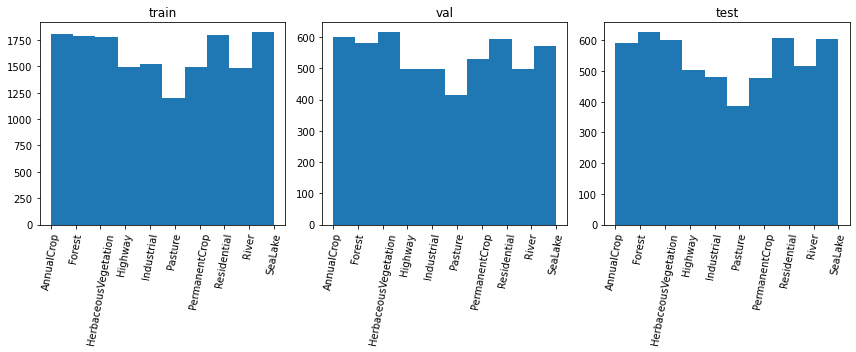

In [6]:
# label distribution

import numpy as np 
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))
ax = plt.subplot(1,3,1)
ax.hist(ds.train_df.label, bins=len(ds.classes))
ax.set_title('train')
ax.set_xticks(list(range(len(ds.classes))))
ax.set_xticklabels(ds.classes, rotation=80)
ax = plt.subplot(1,3,2)
ax.hist(ds.val_df.label, bins=len(ds.classes))
ax.set_title('val')
ax.set_xticks(list(range(len(ds.classes))))
ax.set_xticklabels(ds.classes, rotation=80)
ax = plt.subplot(1,3,3)
ax.hist(ds.test_df.label, bins=len(ds.classes))
ax.set_title('test')
ax.set_xticks(list(range(len(ds.classes))))
ax.set_xticklabels(ds.classes, rotation=80)
plt.tight_layout()
plt.show()

The task consists on the classification of images in 10 classes.

In [7]:
ds.num_classes, ds.classes

(10,
 ['AnnualCrop',
  'Forest',
  'HerbaceousVegetation',
  'Highway',
  'Industrial',
  'Pasture',
  'PermanentCrop',
  'Residential',
  'River',
  'SeaLake'])

Let's visualize some samples from the dataset. You can extract data from the `Dataset`s objects or the `DataLoader`s. `PytorchEO` is designed to work with arbitrary number of inputs and outputs, so we use a `dict` to name the different tensors.

In [8]:
# extract the first sample of the training dataset (you can also access val_ds or test_ds for the other splits)

sample = ds.train_ds[0]

sample.keys(), sample['image'].shape, sample['label']

(dict_keys(['image', 'label']), (64, 64, 13), 4)

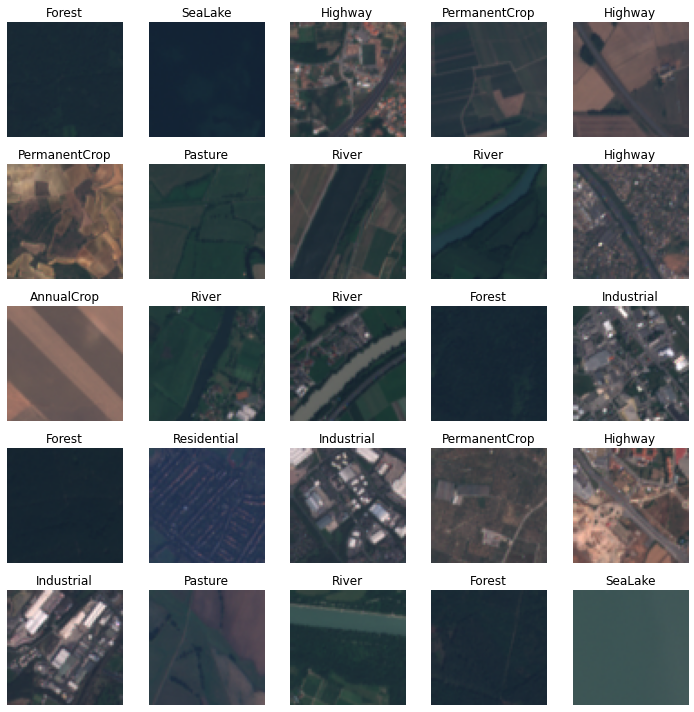

In [9]:
import matplotlib.pyplot as plt
from pytorch_eo.utils.image import to_uint8

# extract a batch of samples (you can also access val_dataloader or test_dataloader for the other splits)

batch = next(iter(ds.train_dataloader()))
imgs, labels = batch['image'], batch['label']

fig = plt.figure(figsize=(10, 10))
th = 4000
for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = plt.subplot(5, 5, i + 1)
    if img.ndim < 3:
        ax.imshow(img, cmap="gray")
    else:
        if img.size(-1) == 3:
            ax.imshow(to_uint8(img, 0, th))
        else:
            ax.imshow(to_uint8(img[...,(3,2,1)], 0, th)) # assuming rgb in channels (3,2,1)
    ax.set_title(ds.classes[label.item()])
    ax.axis('off')
plt.tight_layout()
plt.show()

Let's train an image classifier on this dataset. For that, we need a model. In this case, we are going to use a `resnet18` from the `timm` library. You can use external library or build your own models with `Pytorch`. 

In [10]:
import timm
import torch
from einops import rearrange

class Model(torch.nn.Module):
    def __init__(self, in_chans, pretrained=None, num_classes=10, max_value=4000):
        super().__init__()
        # download resnet18
        self.resnet = timm.create_model(
            'resnet18',
            pretrained=pretrained,
            in_chans=in_chans,
            num_classes=num_classes
        )
        self.max_value = max_value

    def forward(self, x):
        if x.ndim < 4: # 1 band
            x = rearrange(x, 'b h w -> b h w ()')
        # here we have a tensor with dims (b h w c) and type float32 (with values between 0 - 2**16-1)
        # resnet18 is a CNN that need channels first
        x = rearrange(x, 'b h w c -> b c h w')
        # we normalize the values between 0-1
        x = x / self.max_value
        x = x.clip(0, 1)
        # classify
        return self.resnet(x)

Once the `model` is defined, we need to define a `task`. In this case, we use the `ImageClassification` task.

In [11]:
from pytorch_eo.tasks.classification import ImageClassification

model = Model(in_chans=13) # put here the number of bands used

task = ImageClassification(model)

Check everything is working fine by sending a `batch` of inputs to the `task` before training.

In [12]:
out = task(imgs)

out.shape # this should match your expectations (batch size and number of classes)

torch.Size([25, 10])

Now, we can use `Pytorch Lightning` for training the `model` to solve the `task` on the given `dataset`.

In [13]:
import pytorch_lightning as pl

pl.seed_everything(42, workers=True) # this will make your solution reproducible

trainer = pl.Trainer(
    gpus=1,
    precision=16,
    max_epochs=5,
    limit_train_batches=10,
    limit_val_batches=10,
    deterministic=True # this will make your solution reproducible
)

trainer.fit(task, ds)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/juan/Desktop/pytorch_eo/challenges/euroavia_hackathon_21/lightning_logs


data already extracted !
Number of images: 27000
Training samples 16200
Validation samples 5400
Test samples 5400


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | Model            | 11.2 M
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.852    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/juan/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/juan/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/juan/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_e

Training: 0it [00:00, ?it/s]

Once the model is trained, we can evaluate it on the test set to compute the final metrics.

> 🚨 THIS IS THE NUMBER YOU CARE ABOUT

In [ ]:
trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8262962698936462, 'test_loss': 0.5445861220359802}
--------------------------------------------------------------------------------


[{'test_acc': 0.8262962698936462, 'test_loss': 0.5445861220359802}]

: 

And also use it to predict labels on new images.

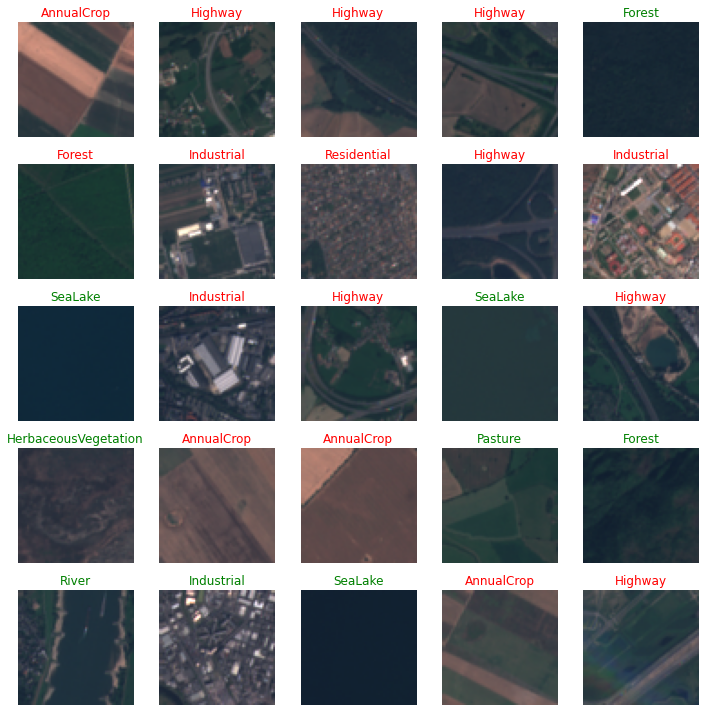

: 

In [ ]:
# extract batch from test dataloader

batch = next(iter(ds.test_dataloader(shuffle=True, batch_size=25)))
imgs, labels = batch['image'], batch['label']

# compute predictions

preds = task.predict(batch)
preds = torch.argmax(preds, axis=1)

# visualize predictions

fig = plt.figure(figsize=(10, 10))
for i, (img, label, pred) in enumerate(zip(imgs, labels, preds)):
	ax = plt.subplot(5, 5, i + 1)
	if img.ndim < 3:
		ax.imshow(img, cmap="gray")
	else:
		if img.size(-1) == 3:
			ax.imshow(to_uint8(img, 0, th))
		else:
			ax.imshow(to_uint8(img[...,(3,2,1)], 0, th)) # assuming rgb in channels (3,2,1)
	gt = ds.classes[label.item()]
	pred = ds.classes[pred.item()]
	ax.set_title(gt, color="green" if gt == pred else 'red')
	ax.axis('off')
plt.tight_layout()
plt.show()

: 

: 